# Ligand-based Screening Neural Networks

# AIGC在药物设计中的应用：基于配体的筛选 - 神经网络

# **Jupyter Notebook** 用于演示如何通过`之前的第一小节的数据 `中的SMILES生成分子表示，并应用神经网络进行基于配体的药物筛选，同时对所有模型进行超参数调优。

---

## 目录

1. [引言](#引言)
2. [导入必要的库](#导入必要的库)
3. [数据加载与预处理](#数据加载与预处理)
    - [加载数据](#加载数据)
    - [转换SMILES为分子对象](#转换smiles为分子对象)
    - [生成活性标签](#生成活性标签)
    - [数据集划分](#数据集划分)
4. [分子表示生成](#分子表示生成)
    - [分子指纹（Molecular Fingerprints）](#分子指纹molecular-fingerprints)
    - [图表示（Graph Representation）](#图表示graph-representation)
    - [连续表示（Continuous Representation）](#连续表示continuous-representation)
5. [机器学习模型训练与评估](#机器学习模型训练与评估)
    - [随机森林（Random Forest）](#随机森林random-forest)
        - [超参数调优](#超参数调优)
    - [支持向量机（SVM）](#支持向量机svm)
        - [超参数调优](#超参数调优-1)
    - [人工神经网络（ANN）](#人工神经网络ann)
        - [模型建设](#模型建设)
        - [模型优化](#模型优化)
    - [卷积神经网络（CNN）](#卷积神经网络cnn)
        - [模型建设](#模型建设-1)
        - [模型优化](#模型优化-1)
6. [多靶点筛选与预测](#多靶点筛选与预测)
    - [数据准备](#数据准备)
    - [模型训练与评估](#模型训练与评估-1)
7. [模型评估与可视化](#模型评估与可视化)
8. [应用场景设计](#应用场景设计)
    - [目标](#目标)
    - [流程](#流程)
    - [模型优化](#模型优化-2)
    - [示例：超参数调优](#示例超参数调优)
9. [结论](#结论)
10. [参考文献](#参考文献)

---

## 引言

药物设计是一个复杂且漫长的过程，传统方法依赖于实验室实验和计算机辅助设计（CADD）工具，通常需要数年甚至数十年的时间才能从初步的化合物筛选到最终的药物上市。随着生物医学数据的爆炸性增长和计算能力的提升，人工智能（AI）技术，特别是AIGC（人工智能生成内容），正逐渐改变这一格局。AIGC不仅能够自动生成新的分子结构，还能优化现有分子、预测药物-靶标相互作用、多靶点药物的发现和优化，从而加速新药的发现和开发过程。

---

## 应用场景设计

### 目标

本项目旨在通过基于配体的筛选，利用神经网络和其他机器学习模型预测化合物的活性，从而加速新药的发现过程。具体应用场景包括：

- **新药发现**：筛选出具有高活性的候选分子，加速药物研发。
- **药物优化**：优化现有分子的结构，提高其活性和选择性。
- **多靶点预测**：预测分子对多个靶标的活性，发现多靶点药物。

### 流程

1. **数据准备**：收集包含SMILES和活性数据的化合物数据集。
2. **分子表示生成**：通过分子指纹、图表示和连续表示等方法，将SMILES转化为机器学习模型可接受的特征。
3. **数据集划分**：将数据集划分为训练集和测试集，确保模型的泛化能力。
4. **模型训练**：使用随机森林、支持向量机、人工神经网络和卷积神经网络等模型进行训练。
5. **模型评估**：通过ROC曲线和AUC值评估模型性能，选择最优模型。
6. **应用预测**：使用最优模型对新化合物进行活性预测，筛选出潜在的高活性候选分子。

### 模型优化

为了提高模型的性能，可以进行以下优化：

- **超参数调优**：使用GridSearchCV或RandomizedSearchCV优化模型的超参数。
- **特征选择**：通过特征重要性分析或降维方法，选择最具预测能力的特征。
- **集成学习**：结合多个模型的预测结果，提升整体的预测性能。

## 导入必要的库

首先，我们需要导入所需的Python库。这些库包括数据处理、分子表示生成、机器学习模型以及可视化工具。


In [22]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# For CNN on SMILES sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 警告信息忽略
import warnings
warnings.filterwarnings('ignore')




In [6]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)

/Users/wangyang/Desktop/AIGC-in-drug-design/02_Ligand-based-screening-neural_networks/data


## 数据加载与预处理

### 加载数据
首先，我们需要加载数据集。数据集包含SMILES、活性值、靶标等信息。

In [7]:
data_path = HERE / '../01_Molecular_representation/data/bioactivities_compounds_VEGFR2.csv'

# 加载数据
df = pd.read_csv(data_path)

# 显示数据的前几行
df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL5189340,0.023,nM,CN(C)c1ccc(/C=N/NC(=O)Cn2nc(Cc3ccc(Cl)cc3)c3cc...,10.638272
1,CHEMBL429743,0.030,nM,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5)cccc4c...,10.522879
2,CHEMBL5186748,0.120,nM,CNC(=O)c1cc(Oc2ccc(NC(=O)c3nn(-c4ccc(Cl)cc4)cc...,9.920819
3,CHEMBL3093581,0.140,nM,O=C(Nc1ccc(Oc2ccc3nc(NC(=O)C4CC4)cn3c2)c(F)c1)...,9.853872
4,CHEMBL3586072,0.140,nM,CNC(=O)c1ccc(-c2ccc(NC(=O)Nc3cc(Br)cc(C(F)(F)F...,9.853872


In [8]:
# 复制一份数据，用于后续的多靶点筛选
df = df.copy()

### 转换SMILES为分子对象

我们需要将SMILES字符串转换为RDKit分子对象，以便生成分子表示。

In [9]:
# 转换SMILES为RDKit分子对象
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# 移除无效的SMILES
df = df[df['mol'].notnull()].reset_index(drop=True)

print(f"有效分子数量: {len(df)}")


有效分子数量: 200


### 生成活性标签

如果数据集中存在`pic50`列，我们将基于该列生成二分类标签：`pIC50 >= 6.3`为活性阳性（1），否则为阴性（0）。如果没有`pic50`列，则进行随机划分。

In [10]:
# 检查是否存在pic50列
if 'pIC50' in df.columns:
    # 生成二分类标签
    df['active'] = df['pIC50'].apply(lambda x: 1 if x >= 8.9 else 0)
    print("使用 pIC50 划分活性标签")
else:
    # 如果没有pic50列，创建一个随机标签
    df['active'] = np.random.randint(0, 2, size=len(df))
    print("没有 pIC50 列，使用随机标签")


使用 pIC50 划分活性标签


### 数据集划分

根据是否存在`pic50`列，选择不同的划分方式。

In [13]:
# 特征和标签
X = df['smiles']
y = df['active']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if 'pIC50' in df.columns else None
)

print(f"训练集大小: {len(X_train)}")
print(f"测试集大小: {len(X_test)}")


训练集大小: 160
测试集大小: 40


## 分子表示生成

### 分子指纹（Molecular Fingerprints）

使用RDKit生成Morgan指纹（也称为ECFP4指纹）

In [14]:
def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# 生成指纹
X_train_fingerprints = np.array([get_morgan_fingerprint(smile) for smile in X_train])
X_test_fingerprints = np.array([get_morgan_fingerprint(smile) for smile in X_test])

print("分子指纹生成完成")


分子指纹生成完成


### 图表示（Graph Representation）

利用RDKit生成基于图的分子描述符，例如分子描述符。

In [15]:
def get_molecular_descriptors(mol):
    descriptors = {}
    for desc_name, func in Descriptors.descList:
        descriptors[desc_name] = func(mol)
    return descriptors

# 生成分子描述符
X_train_graph = df.loc[X_train.index, 'mol'].apply(get_molecular_descriptors).apply(pd.Series).fillna(0).values
X_test_graph = df.loc[X_test.index, 'mol'].apply(get_molecular_descriptors).apply(pd.Series).fillna(0).values

print("图表示生成完成")


图表示生成完成


## 连续表示（Continuous Representation）
使用PCA将指纹降维至较低的维度，以获得连续表示。

In [16]:
from sklearn.decomposition import PCA

# 标准化指纹
scaler = StandardScaler()
X_train_fingerprints_scaled = scaler.fit_transform(X_train_fingerprints)
X_test_fingerprints_scaled = scaler.transform(X_test_fingerprints)

# PCA降维
pca = PCA(n_components=100, random_state=RANDOM_STATE)
X_train_continuous = pca.fit_transform(X_train_fingerprints_scaled)
X_test_continuous = pca.transform(X_test_fingerprints_scaled)

print("连续表示生成完成")


连续表示生成完成


## 机器学习模型训练与评估

### 随机森林（Random Forest）

#### 模型训练

随机森林分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.87      0.97      0.92        35

    accuracy                           0.85        40
   macro avg       0.44      0.49      0.46        40
weighted avg       0.76      0.85      0.80        40


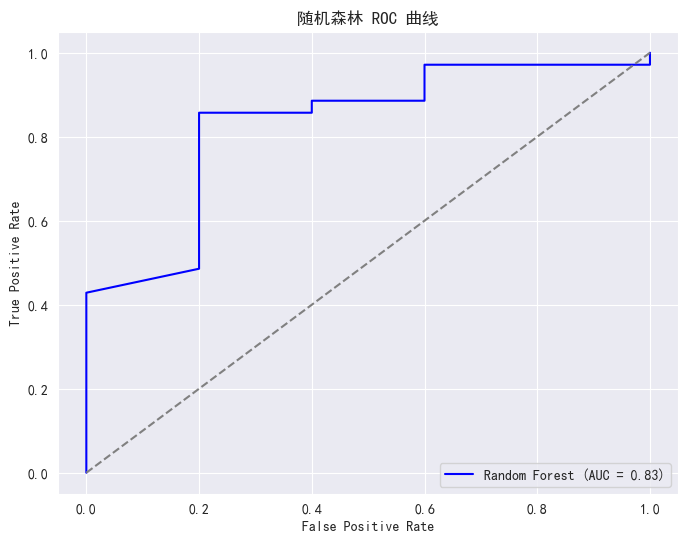

In [20]:
# 训练随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train_fingerprints, y_train)

# 预测概率
y_pred_rf_proba = rf.predict_proba(X_test_fingerprints)[:, 1]

# 输出分类报告
print("随机森林分类报告:")
print(classification_report(y_test, rf.predict(X_test_fingerprints)))
# 计算AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('随机森林 ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / 'rf_roc_curve.png', dpi=300)
plt.show()




#### 超参数调优

使用GridSearchCV对随机森林进行超参数调优。

Fitting 5 folds for each of 27 candidates, totalling 135 fits
最佳参数: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
最佳AUC: 0.7268
最佳随机森林分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.88      1.00      0.93        35

    accuracy                           0.88        40
   macro avg       0.44      0.50      0.47        40
weighted avg       0.77      0.88      0.82        40


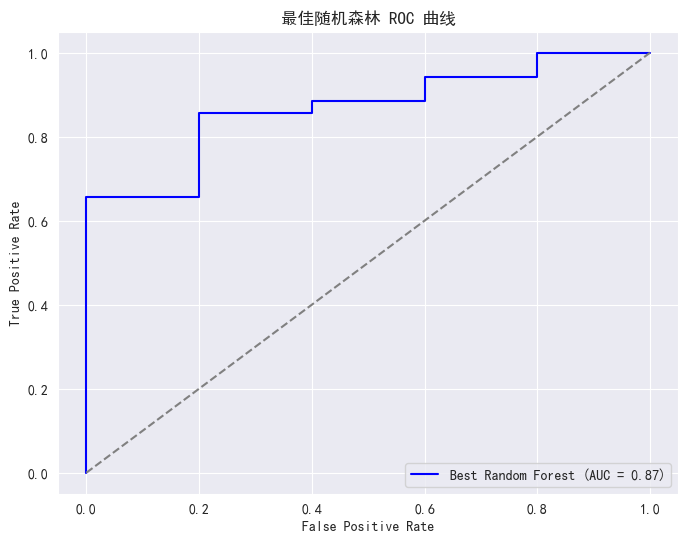

In [23]:
# 定义超参数网格
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 初始化随机森林
rf_grid = RandomForestClassifier(random_state=RANDOM_STATE)

# 使用GridSearchCV进行超参数调优
grid_search_rf = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 执行网格搜索
grid_search_rf.fit(X_train_fingerprints, y_train)

print(f"最佳参数: {grid_search_rf.best_params_}")
print(f"最佳AUC: {grid_search_rf.best_score_:.4f}")

# 使用最佳参数训练随机森林
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf_proba = best_rf.predict_proba(X_test_fingerprints)[:, 1]

# 计算AUC
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, y_pred_best_rf_proba)
roc_auc_best_rf = auc(fpr_best_rf, tpr_best_rf)

# 输出分类报告
print("最佳随机森林分类报告:")
print(classification_report(y_test, best_rf.predict(X_test_fingerprints)))

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_rf, tpr_best_rf, color='blue', label=f'Best Random Forest (AUC = {roc_auc_best_rf:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('最佳随机森林 ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / 'best_rf_roc_curve.png', dpi=300)
plt.show()


### 支持向量机（SVM）

#### 模型训练

支持向量机分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.88      1.00      0.93        35

    accuracy                           0.88        40
   macro avg       0.44      0.50      0.47        40
weighted avg       0.77      0.88      0.82        40


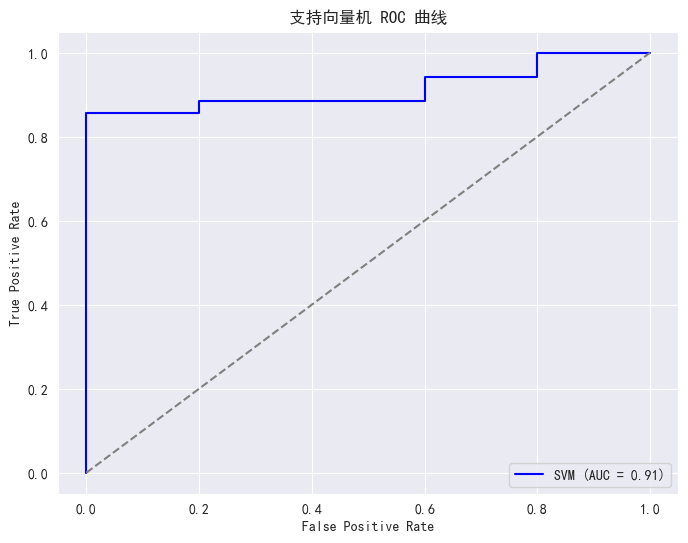

In [25]:
# 训练SVM模型
svm = SVC(probability=True, random_state=RANDOM_STATE)
svm.fit(X_train_fingerprints, y_train)

# 预测概率
y_pred_svm_proba = svm.predict_proba(X_test_fingerprints)[:, 1]

# 输出分类报告
print("支持向量机分类报告:")
print(classification_report(y_test, svm.predict(X_test_fingerprints)))
# 计算AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('支持向量机 ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA /'svm_roc_curve.png', dpi=300)
plt.show()




#### 超参数调优

使用GridSearchCV对SVM进行超参数调优。

Fitting 5 folds for each of 18 candidates, totalling 90 fits
最佳参数: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
最佳AUC: 0.7393
最佳SVM分类报告:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.94      0.94      0.94        35

    accuracy                           0.90        40
   macro avg       0.77      0.77      0.77        40
weighted avg       0.90      0.90      0.90        40


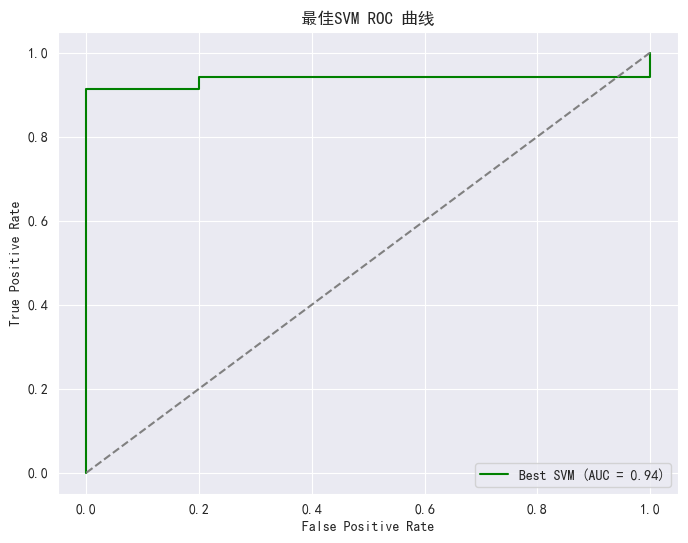

In [26]:
# 定义超参数网格
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# 初始化SVM
svm_grid = SVC(probability=True, random_state=RANDOM_STATE)

# 使用GridSearchCV进行超参数调优
grid_search_svm = GridSearchCV(
    estimator=svm_grid,
    param_grid=param_grid_svm,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 执行网格搜索
grid_search_svm.fit(X_train_fingerprints, y_train)

print(f"最佳参数: {grid_search_svm.best_params_}")
print(f"最佳AUC: {grid_search_svm.best_score_:.4f}")

# 使用最佳参数训练SVM
best_svm = grid_search_svm.best_estimator_
y_pred_best_svm_proba = best_svm.predict_proba(X_test_fingerprints)[:, 1]

# 计算AUC
fpr_best_svm, tpr_best_svm, _ = roc_curve(y_test, y_pred_best_svm_proba)
roc_auc_best_svm = auc(fpr_best_svm, tpr_best_svm)

# 输出分类报告
print("最佳SVM分类报告:")
print(classification_report(y_test, best_svm.predict(X_test_fingerprints)))

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_svm, tpr_best_svm, color='green', label=f'Best SVM (AUC = {roc_auc_best_svm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('最佳SVM ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / 'best_svm_roc_curve.png', dpi=300)
plt.show()


### 人工神经网络（ANN）

#### 模型建设

构建一个简单的全连接神经网络。

In [27]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.relu1(self.fc1(x))
        out = self.relu2(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out
# 实例化模型
input_size = X_train_fingerprints.shape[1]
model = ANN(input_size)

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



#### 模型优化

创建数据集、训练模型，并进行评估。

In [28]:
# 创建数据集
class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MoleculeDataset(X_train_continuous, y_train)
test_dataset = MoleculeDataset(X_test_continuous, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型
ann = ANN(input_size=X_train_continuous.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)

# 训练模型
epochs = 20
ann.train()
for epoch in range(epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = ann(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.4922
Epoch [2/20], Loss: 0.3120
Epoch [3/20], Loss: 0.2254
Epoch [4/20], Loss: 0.1706
Epoch [5/20], Loss: 0.1266
Epoch [6/20], Loss: 0.0952
Epoch [7/20], Loss: 0.0682
Epoch [8/20], Loss: 0.0539
Epoch [9/20], Loss: 0.0404
Epoch [10/20], Loss: 0.0311
Epoch [11/20], Loss: 0.0232
Epoch [12/20], Loss: 0.0173
Epoch [13/20], Loss: 0.0130
Epoch [14/20], Loss: 0.0125
Epoch [15/20], Loss: 0.0112
Epoch [16/20], Loss: 0.0082
Epoch [17/20], Loss: 0.0054
Epoch [18/20], Loss: 0.0053
Epoch [19/20], Loss: 0.0040
Epoch [20/20], Loss: 0.0035


模型评估

In [ ]:
# 评估模型
ann.eval()
y_pred_ann_proba = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = ann(X_batch)
        y_pred_ann_proba.extend(outputs.numpy().flatten())

# 输出分类报告
y_pred_ann = [1 if prob >= 0.5 else 0 for prob in y_pred_ann_proba]
print("人工神经网络分类报告:")
print(classification_report(y_test, y_pred_ann))


#### 超参数调优

使用GridSearchCV对ANN进行超参数调优。

由于ANN是使用PyTorch构建的，无法直接使用GridSearchCV。我们可以使用`skorch`库，它将PyTorch模型封装为sklearn兼容模型。

首先，安装`skorch`：

```python
!pip install skorch
```


然后，进行超参数调优。

In [ ]:
from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

# 定义ANN模型包装
net = NeuralNetBinaryClassifier(
    ANN,
    module__input_size=X_train_continuous.shape[1],
    max_epochs=50,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    batch_size=32,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5)],
    device='cpu'  # Use 'cuda' if GPU is available
)

# 定义参数网格
params = {
    'module__input_size': [X_train_continuous.shape[1]],
    'lr': [0.001, 0.0001],
    'max_epochs': [30, 50],
    'module__fc1__out_features': [512, 256],
    'module__fc2__out_features': [256, 128]
}

# 初始化GridSearchCV
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)

# 执行网格搜索
gs.fit(X_train_continuous, y_train)

print(f"最佳参数: {gs.best_params_}")
print(f"最佳AUC: {gs.best_score_:.4f}")

# 使用最佳模型进行预测
y_pred_best_ann_proba = gs.best_estimator_.predict_proba(X_test_continuous)[:, 1]

# 计算AUC
roc_auc_best_ann = roc_auc_score(y_test, y_pred_best_ann_proba)

# 输出分类报告
y_pred_best_ann = [1 if prob >= 0.5 else 0 for prob in y_pred_best_ann_proba]
print("最佳人工神经网络分类报告:")
print(classification_report(y_test, y_pred_best_ann))

# 绘制ROC曲线
fpr_best_ann, tpr_best_ann, _ = roc_curve(y_test, y_pred_best_ann_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best_ann, tpr_best_ann, color='red', label=f'Best ANN (AUC = {roc_auc_best_ann:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('最佳人工神经网络 ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / 'best_ann_roc_curve.png', dpi=300)
plt.show()


### 卷积神经网络（CNN）

#### 模型建设

这里，我们将使用SMILES字符串的字符级嵌入并应用1D CNN进行预测。

In [ ]:
# 使用CountVectorizer将SMILES转化为特征向量
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X_train_smiles = vectorizer.fit_transform(X_train).toarray()
X_test_smiles = vectorizer.transform(X_test).toarray()

# 标准化
scaler_cnn = StandardScaler()
X_train_smiles_scaled = scaler_cnn.fit_transform(X_train_smiles)
X_test_smiles_scaled = scaler_cnn.transform(X_test_smiles)

# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self, input_size, num_classes=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (input_size // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.relu3(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return out


#### 模型优化

创建数据集、训练模型，并进行评估。

In [ ]:
# 创建数据集
class SMILESDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset_cnn = SMILESDataset(X_train_smiles_scaled, y_train)
test_dataset_cnn = SMILESDataset(X_test_smiles_scaled, y_test)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=32, shuffle=False)

# 初始化模型
input_size_cnn = X_train_smiles_scaled.shape[1]
cnn = SimpleCNN(input_size=input_size_cnn)
criterion_cnn = nn.BCELoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)

# 训练模型
epochs_cnn = 10
cnn.train()
for epoch in range(epochs_cnn):
    running_loss = 0.0
    for X_batch, y_batch in train_loader_cnn:
        optimizer_cnn.zero_grad()
        outputs = cnn(X_batch)
        loss = criterion_cnn(outputs, y_batch)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_cnn)
    print(f"Epoch [{epoch+1}/{epochs_cnn}], Loss: {avg_loss:.4f}")


模型评估

In [ ]:
# 评估模型
cnn.eval()
y_pred_cnn_proba = []
with torch.no_grad():
    for X_batch, _ in test_loader_cnn:
        outputs = cnn(X_batch)
        y_pred_cnn_proba.extend(outputs.numpy().flatten())

# 输出分类报告
y_pred_cnn = [1 if prob >= 0.5 else 0 for prob in y_pred_cnn_proba]
print("卷积神经网络分类报告:")
print(classification_report(y_test, y_pred_cnn))


#### 超参数调优

使用`skorch`对CNN进行超参数调优。

In [ ]:
from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

# 定义CNN模型包装
class SkorchCNN(nn.Module):
    def __init__(self, input_size, num_classes=1):
        super(SkorchCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (input_size // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.pool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.relu3(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return out

# 定义网络
net_cnn = NeuralNetBinaryClassifier(
    SkorchCNN,
    module__input_size=input_size_cnn,
    max_epochs=50,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    batch_size=32,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5)],
    device='cpu'  # Use 'cuda' if GPU is available
)

# 定义参数网格
params_cnn = {
    'lr': [0.001, 0.0001],
    'max_epochs': [20, 30],
    'module__conv1__out_channels': [32, 64],
    'module__fc1__out_features': [128, 256]
}

# 初始化GridSearchCV
grid_search_cnn = GridSearchCV(
    net_cnn,
    params_cnn,
    refit=True,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

# 执行网格搜索
grid_search_cnn.fit(X_train_smiles_scaled, y_train)

print(f"最佳参数: {grid_search_cnn.best_params_}")
print(f"最佳AUC: {grid_search_cnn.best_score_:.4f}")

# 使用最佳模型进行预测
y_pred_best_cnn_proba = grid_search_cnn.best_estimator_.predict_proba(X_test_smiles_scaled)[:, 1]

# 计算AUC
roc_auc_best_cnn = roc_auc_score(y_test, y_pred_best_cnn_proba)

# 输出分类报告
y_pred_best_cnn = [1 if prob >= 0.5 else 0 for prob in y_pred_best_cnn_proba]
print("最佳卷积神经网络分类报告:")
print(classification_report(y_test, y_pred_best_cnn))

# 绘制ROC曲线
fpr_best_cnn, tpr_best_cnn, _ = roc_curve(y_test, y_pred_best_cnn_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best_cnn, tpr_best_cnn, color='purple', label=f'Best CNN (AUC = {roc_auc_best_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('最佳卷积神经网络 ROC 曲线')
plt.legend(loc='lower right')
plt.grid(True)
# 保存图片，dpi=300为图片分辨率
plt.savefig(DATA / 'best_cnn_roc_curve.png', dpi=300)
plt.show()


## 多靶点筛选与预测

### 数据准备

多靶点筛选需要一个包含多个靶标活性的数据集。在`DATA`中，假设每个分子对应多个靶标的活性信息。如果数据集中有多个`pic50`列对应不同的靶标，我们可以进行多标签分类。

## 应用场景设计

### 目标

本项目旨在通过基于配体的筛选，利用神经网络和其他机器学习模型预测化合物的活性，从而加速新药的发现过程。具体应用场景包括：

- **新药发现**：筛选出具有高活性的候选分子，加速药物研发。
- **药物优化**：优化现有分子的结构，提高其活性和选择性。
- **多靶点预测**：预测分子对多个靶标的活性，发现多靶点药物。

### 流程

1. **数据准备**：收集包含SMILES和活性数据的化合物数据集。
2. **分子表示生成**：通过分子指纹、图表示和连续表示等方法，将SMILES转化为机器学习模型可接受的特征。
3. **数据集划分**：将数据集划分为训练集和测试集，确保模型的泛化能力。
4. **模型训练**：使用随机森林、支持向量机、人工神经网络和卷积神经网络等模型进行训练。
5. **模型评估**：通过ROC曲线和AUC值评估模型性能，选择最优模型。
6. **应用预测**：使用最优模型对新化合物进行活性预测，筛选出潜在的高活性候选分子。

### 模型优化

为了提高模型的性能，可以进行以下优化：

- **超参数调优**：使用GridSearchCV或RandomizedSearchCV优化模型的超参数。
- **特征选择**：通过特征重要性分析或降维方法，选择最具预测能力的特征。
- **集成学习**：结合多个模型的预测结果，提升整体的预测性能。